# Benchmarking the Lomb-Scargle implementation in GeochronR

The GeochronR package offers several spectral analysis methods, including the Lomb-Scargle (LS) periodogram (Lomb (1976), Scargle (1982), Scargle (1989)) and its REDFIT variant (Schulz and Mudelsee, 2002),  as implemented in [dlpr](https://cran.r-project.org/web/packages/dplR/index.html). REDFIT supplements some shortcomings of the standard LS method by making use of the Welch's Overlapped Segment Averaging (WOSA) and attempting to correct known biases in the low frequency part of the spectrum.

This notebook walks through an example using the three methods described above using a perfect signal with a periodicity of 20 years ($f_0=1/20$). 

##  Import Pyleoclim and Open an R connection

In [1]:
import pyleoclim as pyleo
%load_ext rpy2.ipython

## Import GeochronR, create the signal, and run Lomb-Scargle and REDFIT from GeoChronR

In [2]:
%%R -o time -o signal -o ls_psd -o redfit_psd
library(geoChronR)

time = seq(1,2000,by=1)
signal = cos(2*pi*1/20*time)

## Lomb Scargle method
spec.ls <- computeSpectraEns(time,signal,method = 'lomb-scargle')
ls_psd <- data.frame("freq" = spec.ls$freqs, "pwr" = spec.ls$power)

## REDFIT method
spec.redfit <- computeSpectraEns(time,signal,method = 'redfit')
redfit_psd <- data.frame("freq" = spec.redfit$freq, "pwr" = spec.redfit$power)

In [3]:
# Pass the data to PSD objects for further plotting

ts=pyleo.Series(time=time,value=signal)
PSD_ls=pyleo.PSD(frequency=ls_psd['freq'],
                amplitude=ls_psd['pwr'],
                label='label',
                timeseries=ts,
                spec_method='R-implemented Lomb Scargle')
PSD_redfit=pyleo.PSD(frequency=redfit_psd['freq'],
                amplitude=redfit_psd['pwr'],
                label='label',
                timeseries=ts,
                spec_method='REDFIT')

## Apply the Lomb-Scargle Implementation from Pyleoclim

The LS method is also implemented in the [Pyleoclim](https://pyleoclim-util.readthedocs.io/en/stable/utils/spectral/lombscargle.html#utils-lombscargle) Python package, where itsimplementation is based on the [Scipy method](https://scipy.github.io/devdocs/generated/scipy.signal.lombscargle.html#scipy.signal.lombscargle), using the algorithm developed by Townsend (2010). For comparison with REDFIT,  the same WOSA and bias correction are applied.

In [4]:
#Pyleoclim implementation
freq=pyleo.utils.wavelet.make_freq_vector(ts.value,method='lomb_scargle')[0:-1]  # remove the Nyquist frequency to avoid bugs
PSD=ts.spectral(method='lomb_scargle',settings={'freq':freq})

## Plots

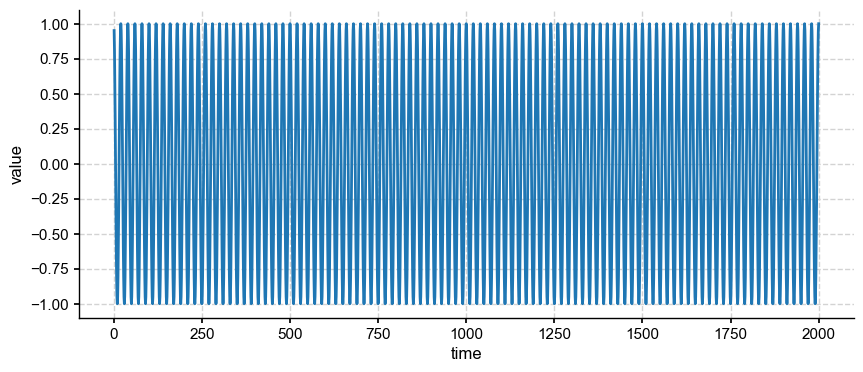

In [5]:
# PLot the series
fig,ax=ts.plot()

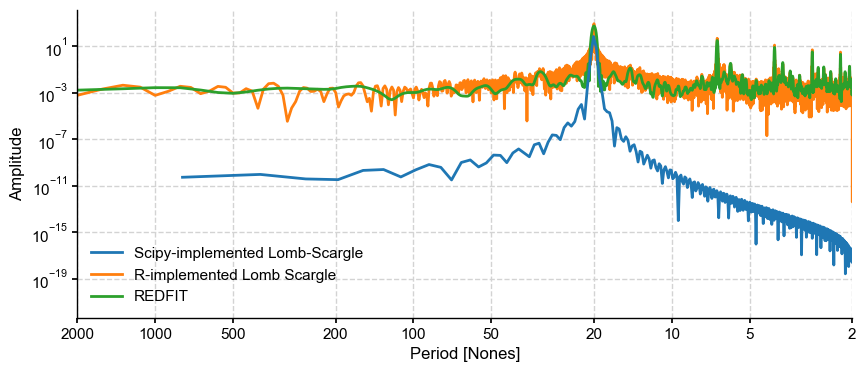

In [6]:
# Plot the PSD
fig,ax = PSD.plot(label='Scipy-implemented Lomb-Scargle', mute=True, zorder=99)
ax =  PSD_ls.plot(label='R-implemented Lomb Scargle',ax=ax, mute=True)
ax =  PSD_redfit.plot(label='REDFIT',ax=ax)
pyleo.showfig(fig)

For such a simple and abundantly sampled harmonic signal, any decent estimator should return something close to a delta function peaked at the $f_0$ frequency. We see that the SciPy implementation of LS achieves this, but the 
 the R and REDFIT implementations are extremely noisy, detecting many spurious peaks at high frequencies. Indeed, the signal to noise ratio is 4 to 15 orders of magnitude smaller in those implementations than in SciPy's, though REDFIT's spectrum is (by virtue of averaging) quite a bit smoother than the standard R LS simplementation. This is quite a substantial difference, for which we cannot find an easy explanation. Indeed, the algorithm is the same, only the numerical implementation differs. At the very least, geoChronR users should be warned that the LS implementation is extremely noisy.

## References
- Lomb, N. R. (1976). Least-squares frequency analysis of unequally spaced data. Astrophysics and Space Science 39, 447-462. 
- Scargle, J. D. (1982). Studies in astronomical time series analysis. II. Statistical aspects of spectral analyis of unvenly spaced data. The Astrophysical Journal, 263(2), 835-853. 
- Scargle, J. D. (1989). Studies in astronomical time series analysis. III. Fourier transforms, aotocorrelation functions, and cross-correlation functions of unevenly-spaced data. . The Astrophysical Journal, 343(2), 874-887. 
- Schulz, M., & Mudelsee, M. (2002). REDFIT: estimating red-noise spectra directly from unevenly spaced paleoclimatic time series. Computers and Geosciences, 28, 421-426. 
- R.H.D. Townsend (2010) Fast calculation of the Lomb-Scargle periodogram using graphics processing units., The Astrophysical Journal Supplement Series, 191, 247-253.